In [1]:
import pandas as pd
import numpy as np

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

RANDOM_STATE = 42

In [2]:
# modelos y métricas
from sklearn import tree
from sklearn.model_selection import train_test_split
import sklearn as sk
# , precision_recall_curve, roc_curve,
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold, KFold, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
# preprocesamiento
from sklearn.preprocessing import MinMaxScaler

# configuración warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)


1. Cargamos y copiamos df train y df test

In [3]:
original = pd.read_csv('./Datasets/hotels_procesado.csv')
# original = pd.read_csv('./Datasets/hotels_train.csv')
df_train = original.copy()
df_test = pd.read_csv('./Datasets/hotels_test.csv')


In [4]:
df_train.head()

,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,id,is_canceled,arrival_date
0,City Hotel,49,2016,September,37,5,1,2,1,0,...,9.0,Sin compania,0,Transient,115.5,0,1,7aa4cc6b-b92c-4061-b21d-4f9e0cac4689,1,2016-09-05
1,Resort Hotel,4,2015,October,44,31,0,1,2,0,...,Sin agente,Sin compania,0,Transient,42.0,1,0,b1428f80-c56c-4ae4-91a9-6962edae08b1,0,2015-10-31
2,City Hotel,25,2016,October,42,13,0,1,2,2,...,9.0,Sin compania,0,Transient,229.0,0,2,2226c018-ea20-4c4e-8f71-ea66aee70d7c,0,2016-10-13
3,City Hotel,26,2016,December,51,12,2,5,2,0,...,154.0,Sin compania,0,Transient,75.0,0,0,314f56dc-2e4d-4298-9bdd-27bb008bffff,1,2016-12-12
4,City Hotel,104,2017,March,12,19,2,5,2,0,...,20.0,Sin compania,0,Transient-Party,75.0,0,1,28c75445-c603-413a-babf-ad377018b592,0,2017-03-19


In [6]:
# Eliminamos las columnas que no vamos a usar para entrenar el modelo
# df.drop(['id', 'arrival_date', 'country', 'assigned_room_type', 'reserved_room_type'], axis='columns', inplace=True)

df_train.drop(['id', 'arrival_date'], axis='columns', inplace=True)
# df_train.drop(['id', 'reservation_status_date'], axis='columns', inplace=True)


In [7]:
# convertir 'sin compania' a 0

# df['company'] = df['company'].apply(lambda x: 0 if x == 'Sin compania' else x).astype('float64').astype('int64')
# # idem for agent
# df['agent'] = df['agent'].apply(lambda x: 0 if x == 'Sin agente' else x).astype('float64').astype('int64')

df_train['company'] = df_train['company'].fillna(0).astype('int64')
df_train['agent'] = df_train['agent'].fillna(0).astype('int64')
df_train['country'] = df_train['country'].fillna('Desconocido')
df_train['children'] = df_train['children'].fillna(0).astype('int64')


ValueError: invalid literal for int() with base 10: 'Sin compania'

In [ ]:
df_train.isna().sum().sum()

In [ ]:
df_test.dtypes

In [ ]:
df_test.isna().sum()

In [ ]:
# children to int
df_test['children'] = df_test['children'].astype('int64')


In [ ]:
# en el df_test, trato las columnas como el df_train
# df_test.drop(['reservation_status_date', 'country', 'assigned_room_type', 'reserved_room_type'], axis='columns', inplace=True)
df_test.drop(['reservation_status_date'], axis='columns', inplace=True)


In [ ]:
# convertir nulos a 0
df_test['company'] = df_test['company'].fillna(0).astype('int64')
df_test['agent'] = df_test['agent'].fillna(0).astype('int64')
df_test['country'] = df_test['country'].fillna('Desconocido')

In [ ]:
df_test.isna().sum()

In [ ]:
# df_test = pd.get_dummies(df_test, columns=['hotel', 'arrival_date_month', 'meal', 'market_segment','distribution_channel', 'deposit_type', 'customer_type'], drop_first=True)
df_test = pd.get_dummies(df_test, columns=['hotel', 'arrival_date_month', 'meal', 'market_segment','distribution_channel', 'deposit_type', 'customer_type', 'reserved_room_type', 'assigned_room_type', 'country'], drop_first=True)

In [ ]:
df_test.columns

In [ ]:
df_test.dtypes

In [ ]:
df_train.info()

In [ ]:
# Encodeamos las variables categóricas
# df = pd.get_dummies(df, columns=['hotel', 'arrival_date_month', 'meal', 'market_segment', 'distribution_channel', 'deposit_type', 'customer_type'], drop_first=True)
df_train = pd.get_dummies(df_train, columns=['hotel', 'arrival_date_month', 'meal', 'market_segment',
                    'distribution_channel', 'deposit_type', 'customer_type', 'reserved_room_type', 'assigned_room_type', 'country'], drop_first=True)
df_train.dtypes

In [ ]:
df_train.columns

In [ ]:
_train = df_train.copy()
_test = df_test.copy()
# combinamos train y test para poder hacer el preprocesamiento
df = pd.concat([_train, _test], axis=0, ignore_index=True)
# sacar todas las columnas excepto 'reserved_room_type', 'assigned_room_type', 'country
# df = df[['reserved_room_type', 'assigned_room_type', 'country']]

# dummies
# df = pd.get_dummies(
#     df, columns=['reserved_room_type', 'assigned_room_type', 'country'])
df.dtypes


In [ ]:
# get columns name of df
columns_total = df.columns
columns_train = df_train.columns
columns_test = df_test.columns

In [ ]:
# join columns_train and columns_test
# columns_train_test = columns_train.union(columns_test)

In [ ]:
nuevas_columns_train = columns_total.difference(columns_train)
nuevas_columns_test = columns_total.difference(columns_test)

In [ ]:
nuevas_columns_train

In [ ]:
nuevas_columns_test

In [ ]:
# add nuevas_columnas_train a df_train
for col in nuevas_columns_train:
        df_train[col] = 0

# add nuevas_columnas_test a df_test
for col in nuevas_columns_test:
        df_test[col] = 0

In [ ]:
df_train.shape

In [ ]:
df_test.shape

In [ ]:
a = df_test.columns
b = df_train.columns
a.difference(b)

In [ ]:
df_train.drop('id', axis='columns', inplace=True)
df_test.drop('is_canceled', axis='columns', inplace=True)
df_train = df_train.reindex(sorted(df_train.columns), axis=1)
df_test = df_test.reindex(sorted(df_test.columns), axis=1)


In [ ]:
#Creo un dataset con los features que voy a usar para clasificar
ds_trabajo_x = df_train.drop(['is_canceled'], axis='columns', inplace=False)

#Creo un dataset con la variable target
ds_trabajo_y = df_train['is_canceled'].copy()

#Genero los conjuntos de train y de test
x_train, x_test, y_train, y_test = train_test_split(ds_trabajo_x,
                                                    ds_trabajo_y, 
                                                    test_size=0.2,  #proporcion 80/20
                                                    random_state=RANDOM_STATE) #semilla

#Verifico Cantidad de Datos en cada set
print('# Datos Entrenamiento: {}'.format(len(x_train)))
print('# Datos Prueba: {}'.format(len(x_test)))

#Verifico como quedaron balanceados
for split_name, split in zip(['% Positivos Entrenamiento','% Positivos Prueba'],[y_train,y_test]):
  print('{}: {:.3f}'.format(split_name,pd.Series(split).value_counts(normalize=True)[1]*100))

# Datos Entrenamiento: 49530
# Datos Prueba: 12383
% Positivos Entrenamiento: 49.915
% Positivos Prueba: 50.214


In [ ]:
#Cantidad de combinaciones que quiero porbar

n=10

#Conjunto de parámetros que quiero usar
# params_grid = {'criterion':['gini','entropy'],
#                'max_depth': [None],
#                'min_samples_split': list(range(2,30)),
#                'min_samples_leaf':list(range(1,10)),
#                'max_features': list(range(1,10)),
#                'ccp_alpha':np.linspace(0,0.005,n), 
#                }

params_grid = {
    'max_depth': [None],
    'max_features': [0.7],
    'min_samples_split': [25],
    'min_samples_leaf': [1]
}
                
#Cantidad de splits para el Cross Validation
folds=10

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

#Clasificador
base_tree = DecisionTreeClassifier()

#Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(sk.metrics.f1_score)

#Random Search Cross Validation
randomcv = RandomizedSearchCV(estimator=base_tree,
                              param_distributions = params_grid,
                              scoring=scorer_fn,
                              cv=kfoldcv)

#Busco los hiperparamtros que optimizan F1 Score
randomcv.fit(x_train,y_train);

In [ ]:
# Mejores hiperparametros del arbol
print(randomcv.best_params_)
# Mejor métrica
print(randomcv.best_score_)

In [ ]:
# Construct Grid Parameters
from sklearn.model_selection import GridSearchCV

folds = 10

# Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

params_grid = {
    'max_depth': [None],
    'max_features': [0.7],
    'min_samples_split': [25],
    'min_samples_leaf': [1]
}

# Clasificador
base_tree = DecisionTreeClassifier()

# Perform Grid Search
gs = GridSearchCV(base_tree, params_grid,
                     cv=kfoldcv,
                     scoring='accuracy')

gs.fit(x_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [None], 'max_features': [0.7],
                         'min_samples_leaf': [1], 'min_samples_split': [25]},
             scoring='accuracy')

In [ ]:
# Mejores hiperparametros del arbol
print(gs.best_params_)
# Mejor métrica
print(gs.best_score_)

{'max_depth': None, 'max_features': 0.7, 'min_samples_leaf': 1, 'min_samples_split': 25}
0.8395114072279426


In [ ]:
#Atributos considerados y su importancia
best_tree = gs.best_estimator_
feat_imps = best_tree.feature_importances_

for feat_imp,feat in sorted(zip(feat_imps,ds_trabajo_x.columns)):
  if feat_imp>0:
    print('{}: {}'.format(feat,feat_imp))

country_LBN: 4.4580193032932754e-05
country_TUN: 5.106060612658365e-05
country_MOZ: 5.36439770755909e-05
country_EST: 5.8935207453106564e-05
country_Desconocido: 5.9881655201595715e-05
country_ISL: 6.879963351501099e-05
country_GRC: 6.985414990702616e-05
country_DOM: 7.30010595456731e-05
country_DZA: 7.349681974652435e-05
country_NZL: 7.612861125549945e-05
country_MAC: 8.045428860714686e-05
country_GIB: 8.255597519885869e-05
country_TWN: 8.310970592994907e-05
country_GEO: 8.325560210732362e-05
country_PAK: 8.35788140478649e-05
deposit_type_Refundable: 8.562856460063744e-05
country_SAU: 8.590698977779205e-05
country_SVK: 8.630748856463272e-05
country_MDV: 8.67107945859625e-05
country_CYP: 9.095889445432253e-05
distribution_channel_Undefined: 9.301941249169499e-05
country_NAM: 9.344908882149296e-05
country_BLR: 9.739137077002157e-05
country_QAT: 9.816187122749509e-05
reserved_room_type_H: 9.883433419479123e-05
market_segment_Complementary: 0.00011602471879545791
distribution_channel_TA/T

In [ ]:
# Creo el clasificador
arbol = tree.DecisionTreeClassifier(random_state=RANDOM_STATE).set_params(**gs.best_params_)

# Entreno el modelo sin la columnna id

modelo = arbol.fit(X=x_train, y=y_train)

In [ ]:
# Realizamos una predicción sobre el set de test
y_pred = modelo.predict(x_test)

In [ ]:
# Scoring
print(f'Best Training Accuracy: {modelo.score(x_train, y_train)}')
print(f'Best Testing Accuracy: {modelo.score(x_test, y_test)}')
print(
    f'Cross-val-score: {cross_val_score(randomcv.best_estimator_, ds_trabajo_x, ds_trabajo_y, cv=StratifiedKFold(shuffle=True)).mean()}')

Best Training Accuracy: 0.9162123965273572
Best Testing Accuracy: 0.8468868610191391
Cross-val-score: 0.8443137983119477


Text(50.722222222222214, 0.5, 'True')

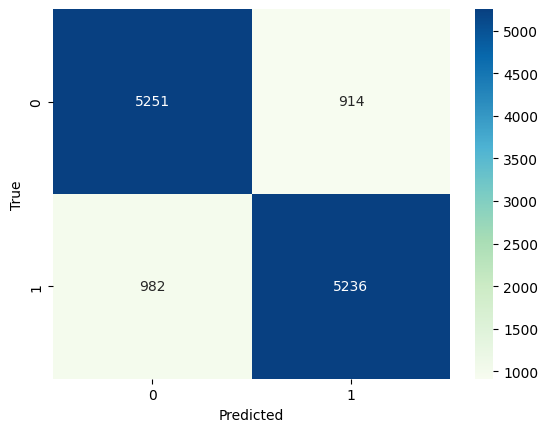

In [ ]:
# Creo la matriz de confusión
tabla = confusion_matrix(y_test, y_pred)

# Grafico la matriz de confusión
sns.heatmap(tabla, cmap='GnBu', annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

In [ ]:
# Calculo las métricas en el conjunto de evaluación
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred,)
precision = precision_score(y_test, y_pred)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

Accuracy: 0.8468868610191391
Recall: 0.8420714055966548
Precision: 0.8513821138211383
f1 score: 0.8467011642949548


In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.84      0.85      0.85      6165
           1       0.85      0.84      0.85      6218

    accuracy                           0.85     12383
   macro avg       0.85      0.85      0.85     12383
weighted avg       0.85      0.85      0.85     12383



In [ ]:
modelo.classes_

array([0, 1], dtype=int64)

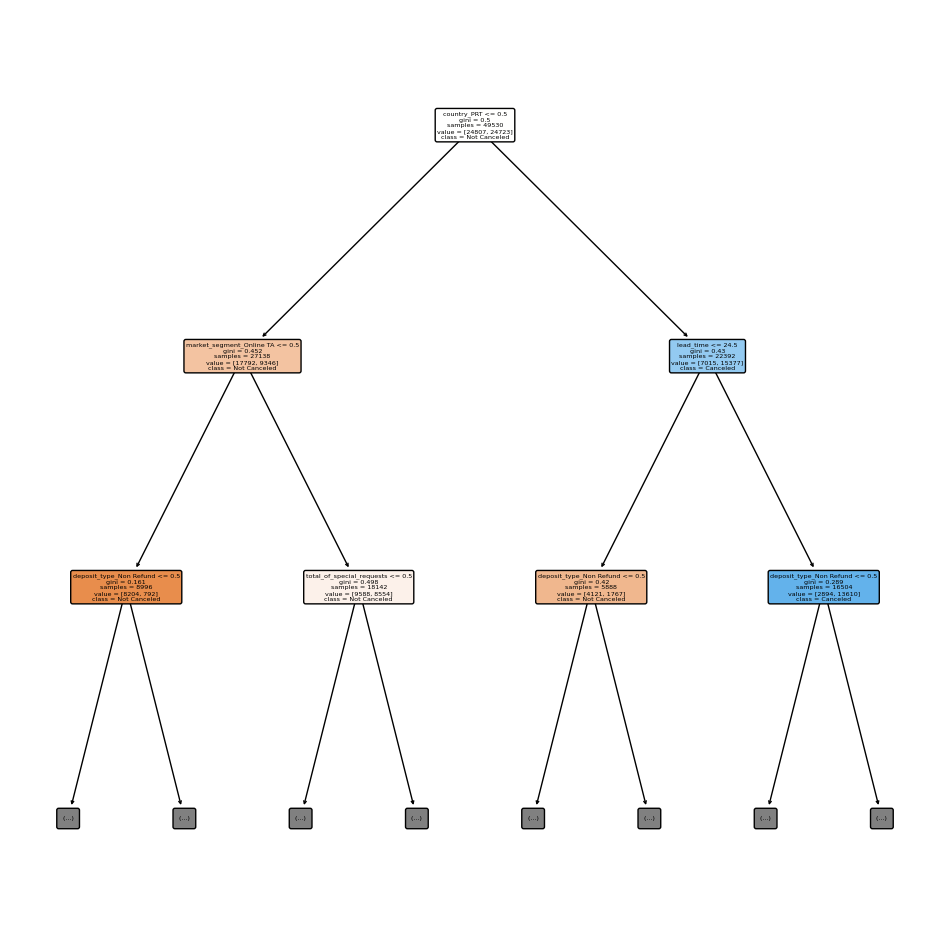

In [ ]:
plt.figure(figsize=(12, 12))

tree_plot = tree.plot_tree(modelo,
                           max_depth=2,
                           feature_names=ds_trabajo_x.columns.to_list(),
                           filled=True,
                           rounded=True,
                           class_names=['Not Canceled', 'Canceled'])

plt.show(tree_plot)

In [ ]:
sorted(list(zip(ds_trabajo_x.columns.to_list(),
       modelo.feature_importances_)), key=lambda x: -x[1])

[('lead_time', 0.20439908567165055),
 ('country_PRT', 0.14943015751004815),
 ('market_segment_Online TA', 0.09368200045624142),
 ('deposit_type_Non Refund', 0.07232782891524248),
 ('total_of_special_requests', 0.0642412622886105),
 ('agent', 0.06362029781553126),
 ('required_car_parking_spaces', 0.04209512526792076),
 ('adr', 0.03955476114026049),
 ('arrival_date_year', 0.03146833806989413),
 ('arrival_date_week_number', 0.03126166130119482),
 ('arrival_date_day_of_month', 0.020869160184217587),
 ('previous_cancellations', 0.018998350716646635),
 ('customer_type_Transient', 0.016845028515775826),
 ('booking_changes', 0.015116190751630895),
 ('stays_in_week_nights', 0.014988835838610328),
 ('stays_in_weekend_nights', 0.009469921118759604),
 ('customer_type_Transient-Party', 0.006729227230069823),
 ('market_segment_Direct', 0.004368171973165564),
 ('previous_bookings_not_canceled', 0.004344081470738861),
 ('adults', 0.003959215799258805),
 ('hotel_Resort Hotel', 0.003927984488706041),
 (

In [ ]:
X_submission = df_test.select_dtypes(exclude=['object'])
y_pred_test = modelo.predict(X_submission)

In [ ]:
df_submission = pd.DataFrame({'id': df_test['id'], 'is_canceled': y_pred_test})
df_submission.head()

,id,is_canceled
0,e6d0d58a-ab96-44d3-b28f-85df1cc15f1e,1
1,aba9aac2-4495-4645-a60e-90328713c999,1
2,b345b5dc-c804-4d77-a39f-1f4e65d1f1ad,1
3,ce1b400e-afa1-4946-bdff-004b859eb61c,1
4,c4fbec0d-8e2e-4db2-9d4f-a6ccb9f51214,1


In [ ]:
df_submission.to_csv('submission04.csv', index=False)